# EEG - Flow

## 4b. ICA compare components selections

Last edit: 24.04.2023 11:31
@anguyen

In [39]:
import os
from datetime import datetime
import matplotlib.pyplot as plt

from mne import pick_types, read_annotations
from mne.io import read_info, read_raw_fif
from mne.io.constants import FIFF
from mne.preprocessing import ICA, read_ica
from mne.viz import set_browser_backend

from eeg_flow.config import load_config
from eeg_flow.utils.bids import get_fname, get_folder
from eeg_flow.utils.concurrency import lock_files

%matplotlib qt
set_browser_backend('qt')

_, DERIVATIVES_FOLDER_ROOT, EXPERIMENTER = load_config()

The parameters of the file to process are defined below. Locks are created to prevent someone else from running the same task and from writing the same derivatives.

In [2]:
PARTICIPANT = 22        # int
GROUP       = 7         # int [1, 2, 3, 4, 5, 6, 7, 8]
TASK        = "oddball" # str [oddball, UT]
RUN         = 2         # int [1, 2]

REVIEWER1 = "anguyen"
REVIEWER2 = "anguyen2"

FNAME_STEM = get_fname(PARTICIPANT, GROUP, TASK, RUN)
DERIVATIVES_SUBFOLDER = get_folder(
    DERIVATIVES_FOLDER_ROOT, PARTICIPANT, GROUP, TASK, RUN
)

DERIVATIVES_ICA = DERIVATIVES_SUBFOLDER / "plots" / "ica"

# create locks
derivatives = [
    DERIVATIVES_SUBFOLDER
    / (f"{FNAME_STEM}_step4b_reviewed-1st-ica.fif"),
    DERIVATIVES_SUBFOLDER
    / (f"{FNAME_STEM}_step4b_reviewed-2nd-ica.fif"),
]

locks = lock_files(*derivatives)

# load previous steps
## load raw recording
raw = read_raw_fif(
    DERIVATIVES_SUBFOLDER / (FNAME_STEM + "_step1_raw.fif"),
    preload=True,
)
## load following annots
info = read_info(
    DERIVATIVES_SUBFOLDER / (FNAME_STEM + "_step2_info.fif")
)
annot = read_annotations(
    DERIVATIVES_SUBFOLDER / (FNAME_STEM + "_step2_oddball_with_bads_annot.fif")
)

# merge info and annots into current raw
raw.info["bads"] = info["bads"]
raw.set_annotations(annot)

# load ICA
fname_ica1_rev1 = DERIVATIVES_SUBFOLDER / (f"{FNAME_STEM}_step4_reviewed-1st-{REVIEWER1}-ica.fif")
# fname_ica2_rev1 = DERIVATIVES_SUBFOLDER / (f"{FNAME_STEM}_step4_reviewed-2nd-{REVIEWER1}-ica.fif")

fname_ica1_rev2 = DERIVATIVES_SUBFOLDER / (f"{FNAME_STEM}_step4_reviewed-1st-{REVIEWER2}-ica.fif")
# fname_ica2_rev2 = DERIVATIVES_SUBFOLDER / (f"{FNAME_STEM}_step4_reviewed-2nd-{REVIEWER2}-ica.fif")

ica1_rev1 = read_ica(fname_ica1_rev1)
# ica2_rev1 = read_ica(fname_ica2_rev1)
ica1_rev2 = read_ica(fname_ica1_rev2)
# ica2_rev2 = read_ica(fname_ica2_rev2)

Opening raw data file L:\EEG_Flow_data\derivatives\sub-P22-G7\sub-P22-G7_task-oddball_run-2\sub-P22-G7_task-oddball_run-2_step1_raw.fif...
    Range : 2606 ... 380418 =      2.545 ...   371.502 secs
Ready.
Reading 0 ... 377812  =      0.000 ...   368.957 secs...
Reading L:\EEG_Flow_data\derivatives\sub-P22-G7\sub-P22-G7_task-oddball_run-2\sub-P22-G7_task-oddball_run-2_step4_reviewed-1st-anguyen-ica.fif ...


C:\Users\anguyen\AppData\Local\Temp\ipykernel_37260\3460102905.py:42: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(annot)


Now restoring ICA solution ...
Ready.
Reading L:\EEG_Flow_data\derivatives\sub-P22-G7\sub-P22-G7_task-oddball_run-2\sub-P22-G7_task-oddball_run-2_step4_reviewed-1st-anguyen2-ica.fif ...
Now restoring ICA solution ...
Ready.


In [3]:
# Filter to final BP (1, 40) Hz
raw_ica_fit1 = raw.copy()
raw_ica_fit1.filter(
    l_freq=1.0,
    h_freq=40.0,
    picks="eeg",
    method="fir",
    phase="zero-double",
    fir_window="hamming",
    fir_design="firwin",
    pad="edge",
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 45.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


<Raw | sub-P22-G7_task-oddball_run-2_step1_raw.fif, 68 x 377813 (369.0 s), ~196.1 MB, data loaded>

In [16]:
ica1_rev2.exclude

[0, 1, 2, 3, 4]

In [21]:
ica1_rev1.exclude

[]

In [24]:
def Intersection(lst1, lst2):
    return set(lst1).intersection(lst2)

# put the labels that are in common on the side
agreed_bads = Intersection(ica1_rev1.exclude,ica1_rev2.exclude)

# remove both common points from both original lists
set(ica1_rev1.exclude) - set(agreed_bads)
set(ica1_rev2.exclude) - set(agreed_bads)

all_rejected = set(ica1_rev1.exclude).union(set(ica1_rev2.exclude))

In [25]:
all_rejected

{0, 1, 2, 3, 4}

In [26]:
agreed_bads

set()

In [28]:
for rej_components in all_rejected:
    print(rej_components)

0
1
2
3
4


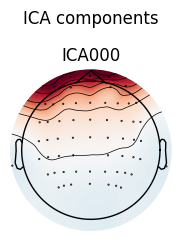

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated


In [83]:
ica1_rev1.plot_components(inst=raw_ica_fit1, picks=[0])

In [85]:
f, ax = plt.subplots(1, 2, figsize=(8, 8))
ica1_rev1.plot_components(inst=raw_ica_fit1, picks=[0], axes=ax[0])
f.tight_layout()


TypeError: 'Axes' object is not iterable

In [84]:
f, ax = plt.subplots(1, 2, figsize=(8, 8))
ica1_rev1.plot_components(inst=raw_ica_fit1, picks=[0], axes=[ax[0]])
f.tight_layout()


UnboundLocalError: local variable 'fig' referenced before assignment

In [ ]:
def plot_compare_ica(ica1_fname1, ica2_fname2):
    # load ICA
    ...
   
    # retrieve experimenter names from fnames
    ...
   
    # list components which don't have the same label
    ...
   
    # create matplotlib figure/axis based on the number of components
    # with 2 axes per component, one with the topographic map and one with
    # text from a plt.text with experimenter/labels
    ...
   
    # plot components with ica.plot_components(axes=...)
    # make sure to provide only half of the axes created.
    ...
   
    # add the text with plt.text on the other axes
   
    return fig, ax


## 4.1 Annotate bad ICs from ICA1 for mastoids
 - At this stage, let's only focus on the mastoids. Look for:
 - heartbeat in the IC-time series
 - muscle/noise on the mastoids on the topographic map

In [ ]:
figs_ica_sources_mastoids = ica1.plot_sources(
    title=fname_stem + " | ICA1 sources Mastoids | " + EXPERIMENTER,
    show=True,
    inst=raw_ica_fit1,
)

In [ ]:
%matplotlib inline
# plot something smaller
# plt.plot([])
figs_ica_comp_mastoids = ica1.plot_components(
    title=FNAME_STEM + " | ICA1 components Mastoids | " + EXPERIMENTER,
    show=True,
    inst=raw_ica_fit1,
)

In [ ]:
%matplotlib qt
figs_ica_comp_mastoids = ica1.plot_components(
    title=FNAME_STEM + " | ICA1 components Mastoids | " + EXPERIMENTER,
    show=True,
    inst=raw_ica_fit1,
)

In [ ]:
ica_folder = DERIVATIVES_SUBFOLDER / "plots" / "ica"
timestampStr = datetime.now().strftime("%Y-%m-%d__%H-%M")
for i, fig in enumerate(figs_ica_comp_mastoids):
    FNAME_ICA1_COMP = (
        DERIVATIVES_ICA / f"allComponents_ICA1_{EXPERIMENTER}_{k+1}_timestampStr.svg"
    )
    fig.savefig(FNAME_ICA1_COMP, transparent=True)

In [ ]:
#save ICA1 here instead? Yes.

In [ ]:
#%% Clean the other channels
# The first step is to prepare the raw object for an ICA, and for suggestions
# from ICLabel. The steps are very similar to the previous ones.
del raw_ica_fit1
raw.drop_channels(["M1", "M2"])

In [ ]:
# filter
raw_ica_fit2 = raw
raw_ica_fit2.filter(
    l_freq=1.0,
    h_freq=100.0,  # Note the higher frequency
    picks="eeg",
    method="fir",
    phase="zero-double",
    fir_window="hamming",
    fir_design="firwin",
    pad="edge",
)

In [ ]:
# change the reference to a common average reference (CAR)
raw_ica_fit2.set_montage(None)
raw_ica_fit2.add_reference_channels(ref_channels="CPz")
raw_ica_fit2.set_montage("standard_1020")
raw_ica_fit2.set_eeg_reference("average", projection=False)
# Note that the CAR is excluding the bad channels.

## 4.2 Annotate bad ICs from ICA2 for EEG
 - At this stage, let's only focus on the mastoids. Look for:
 - heartbeat in the IC-time series
 - muscle/noise on the mastoids on the topographic map


In [ ]:
# Visual inspection
figs_ica_sources = ica2.plot_sources(
    title=FNAME_STEM + " | ICA2 sources | " + EXPERIMENTER, 
    show=True, 
    inst=raw_ica_fit2
)

In [ ]:
%matplotlib inline
figs_ica_comp = ica2.plot_components(
    title=FNAME_STEM + " | ICA2 components | " + EXPERIMENTER,
    show=True,
    inst=raw_ica_fit2
)

In [ ]:
%matplotlib qt
figs_ica_comp = ica2.plot_components(
    title=FNAME_STEM + " | ICA2 components | " + EXPERIMENTER,
    show=True,
    inst=raw_ica_fit2
)

In [ ]:
timestampStr = datetime.now().strftime("%Y-%m-%d__%H-%M")
for i, fig in enumerate(figs_ica_comp):
    FNAME_ICA2_COMP = (
        DERIVATIVES_ICA / f"allComponents_ICA2_{EXPERIMENTER}_{i+1}_timestampStr.svg"
    )
    fig.savefig(FNAME_ICA2_COMP, transparent=True)

## 4.3 Save derivatives

The ICA decomposition can be saved.

In [ ]:
FNAME_ICA1 = DERIVATIVES_SUBFOLDER / (FNAME_STEM + "_step4_reviewed-1st-" + EXPERIMENTER + "-ica.fif")
FNAME_ICA2 = DERIVATIVES_SUBFOLDER / (FNAME_STEM + "_step4_reviewed-2nd-" + EXPERIMENTER + "-ica.fif"")

ica1.save(FNAME_ICA1, overwrite=False)
ica2.save(FNAME_ICA2, overwrite=False)

Regardless of the success of the task, the locks must be released.
If this step is forgotten, someone might have to remove the corresponding `.lock` file manually.

In [ ]:
for lock in locks:
    lock.release()
del locks  # delete would release anyway